In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_df = pd.read_csv("data.csv", parse_dates=["Date"])

format_demand = lambda x: pd.to_numeric(str(x).strip("()"))

data_df["Order_Demand"] = [format_demand(x[1]["Order_Demand"]) for x in data_df.iterrows()]

formatted_df = data_df[data_df["Order_Demand"] != 0].dropna()

print(formatted_df.dtypes)

Product_Code                object
Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                 int64
dtype: object


In [17]:
formatted_df.pivot_table(values="Order_Demand", index="Product_Category", aggfunc=[np.sum, np.mean, np.median, min, max, "count"])

,sum,mean,median,min,max,count
,Order_Demand,Order_Demand,Order_Demand,Order_Demand,Order_Demand,Order_Demand
Product_Category,,,,,,
Category_001,1757473,18.038130,5,1,2075,97431
Category_002,628,8.155844,4,1,60,77
Category_003,392950,95.122246,32,1,1860,4131
Category_004,99046,302.892966,200,1,2400,327
Category_005,199674520,1976.916725,500,10,500000,101003
Category_006,405571330,11501.654189,3000,1,1000000,35262
Category_007,128691531,1570.749799,100,1,1144000,81930
Category_008,17568,11.305019,4,1,200,1554


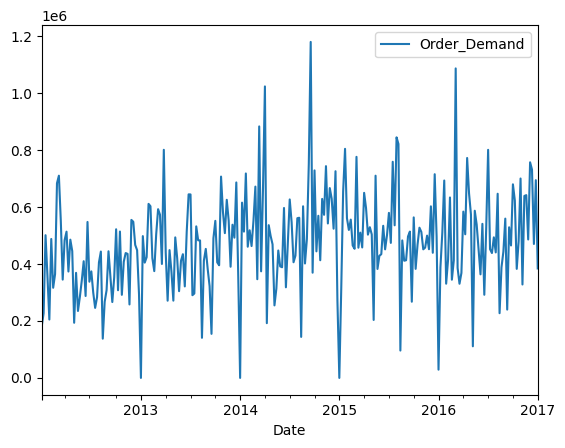

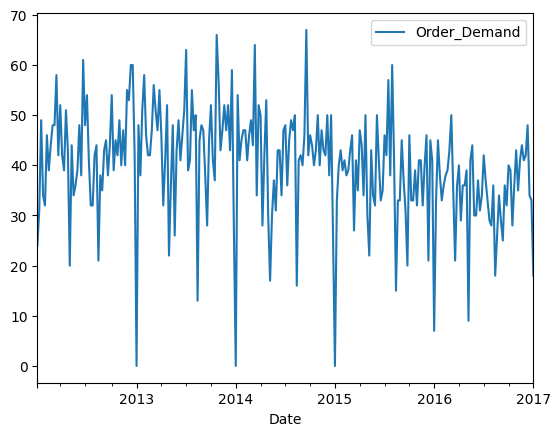

In [66]:
product1295 = formatted_df[formatted_df["Product_Code"] == "Product_1295"]

product1295.pivot_table(values="Order_Demand", index="Date", aggfunc=[np.sum, min, max, "count"])

# grouped_product1295 = product1295.groupby("Date")["Order_Demand"].sum().reset_index()
weekly_product1295 = product1295.groupby(pd.Grouper(key="Date", freq="W")).sum().reset_index()

weekly_product1295.plot(x="Date", y="Order_Demand", kind="line")
# plt.show()

# order_count_product1295 = product1295.groupby("Date")["Order_Demand"].count().reset_index()
weeklyorder_product1295 = product1295.groupby(pd.Grouper(key="Date", freq="W")).count().reset_index()

weeklyorder_product1295.plot(x="Date", y="Order_Demand", kind="line")
plt.show()

In [49]:
product_demand_pivot = formatted_df.pivot_table(values="Order_Demand", index="Product_Code", aggfunc=["count", np.sum])
# print(product_demand_pivot)
order_quantity = product_demand_pivot.sort_values(by=("sum", "Order_Demand"), ascending=False)
order_number = product_demand_pivot.sort_values(by=("count", "Order_Demand"), ascending=False)
print(order_quantity.head())
print(order_number.head())

                    count          sum
             Order_Demand Order_Demand
Product_Code                          
Product_1359        16885    472474000
Product_1248         6323    289117000
Product_0083         1984    210651000
Product_1341         2659    169777000
Product_1295        10464    123303000
                    count          sum
             Order_Demand Order_Demand
Product_Code                          
Product_1359        16885    472474000
Product_1295        10464    123303000
Product_1378         9672     83632700
Product_0620         9391        56789
Product_1286         8804    101566400


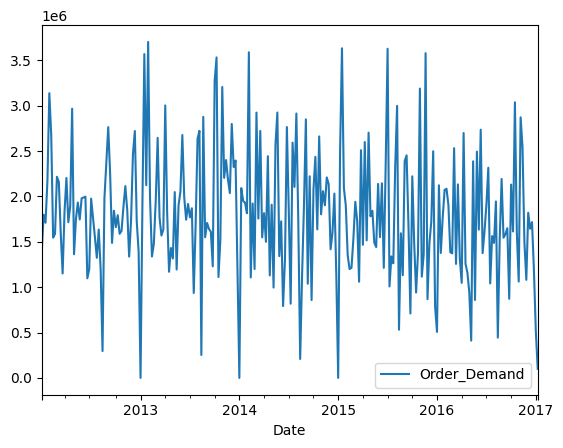

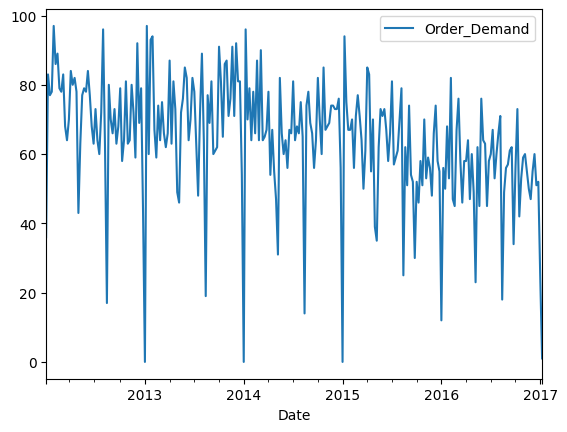

In [68]:
product1359 = formatted_df[formatted_df["Product_Code"] == "Product_1359"]

# print(product1359.pivot_table(values="Order_Demand", index="Date", aggfunc=[np.sum, min, max, "count"]))

# grouped_product1295 = product1295.groupby("Date")["Order_Demand"].sum().reset_index()
weekly_product1359 = product1359.groupby(pd.Grouper(key="Date", freq="W")).sum().reset_index()

weekly_product1359.plot(x="Date", y="Order_Demand", kind="line")
# plt.show()

# order_count_product1295 = product1295.groupby("Date")["Order_Demand"].count().reset_index()
weeklyorder_product1359 = product1359.groupby(pd.Grouper(key="Date", freq="W")).count().reset_index()

weeklyorder_product1359.plot(x="Date", y="Order_Demand", kind="line")
plt.show()